In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))
import numpy as np
import matplotlib.pylab as plt
import xarray as xr
import rioxarray as rxr
import pandas as pd
import pickle
from src.models.earhlab_lib import hyper_plsr
from src.features import build_features


In [ ]:
# Download the data from google drive
from src.data.make_dataset import gdown_file
url_tif = "https://drive.google.com/uc?id=1UOEeyzHW-h0el2Qzk1o7BiSsqT8f8ax2"
url_tfw = "https://drive.google.com/uc?id=1I3Ns7sQ4ETFVsYD6sEQXzR65xHtyFIfD"
gdown_file(url_tif,"../data/raw/hyper_image.tif")
gdown_file(url_tfw, "../data/raw/hyper_image.tfw")

In [2]:

# Read the csv (training) data and the hyperspectral image
csv_data = pd.read_csv("../data/raw/Data.csv")
hyper_img = rxr.open_rasterio("../data/raw/hyper_image.tif")
# Make the band number to start with 0 to make it coonsistent with python indexing
hyper_img["band"] = hyper_img["band"] - 1

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [3]:
# Raw data exploration
print((f"\nNumber of observations before cleaning: {csv_data.shape[0]-1}\n"
f"Number of spectral bands (features): {csv_data.shape[1]-1}\n"))
print(csv_data)
print(hyper_img)


Number of observations before cleaning: 195
Number of spectral bands (features): 373

     nitrogen  381.36026  386.368927  391.377594  396.386292  401.394958  \
0         NaN  -0.015750   -0.000410    0.002750    0.010720    0.010480   
1         NaN  -0.025010   -0.011980   -0.010180   -0.003490   -0.003820   
2         NaN  -0.010730    0.008020    0.011260    0.020860    0.021050   
3         NaN  -0.008530    0.008100    0.010440    0.018360    0.016780   
4    1.223945  -0.020460   -0.005830   -0.002950    0.004900    0.004650   
..        ...        ...         ...         ...         ...         ...   
191  2.166600   0.005535    0.052470    0.058871    0.070103    0.072897   
192  2.408300   0.003750    0.047256    0.053006    0.063522    0.065950   
193  2.600000   0.007845    0.058672    0.063979    0.076104    0.079309   
194       NaN   0.007469    0.057818    0.064453    0.075616    0.079102   
195  2.400000   0.005595    0.053338    0.058369    0.069548    0.072299   



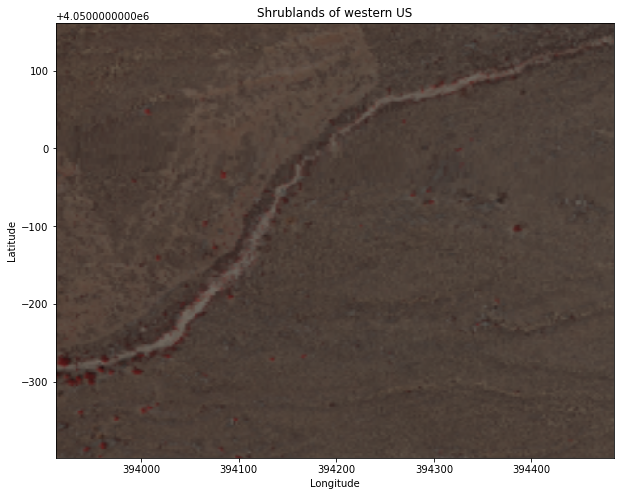

In [4]:
# plot the false color composite of the image: 

plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
hyper_img.isel(band=[104,62,42]).plot.imshow(ax=ax)
ax.set_title("Shrublands of western US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig("../reports/figures/CIR_image.png")



## Cleaning the training data:
1. Remove observations with nan values (no nitrogen measured).
2. Remove the columns with negative reflectance.
3. Remove water absorption bands.    

In [50]:
# Clean CSV file
X, y, non_negative_columns, water_bands, wl = build_features.clean_data(csv_data)
cleaned_csv =np.c_[y, X]
cols = [str(wl[i]) for i in range(len(wl))]
cols.insert(0,"Nitrogen[%]")
cleaned_csv_pd = pd.DataFrame(cleaned_csv,index=None, columns=cols)
cleaned_csv_pd.to_csv("../data/processed/cleaned_csv.csv",index=False)

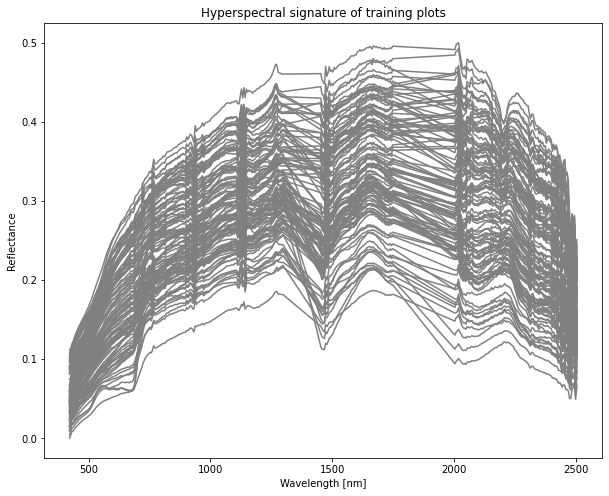

In [51]:
# plot the spectr in the training set:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
plt.plot(wl,X.T,color="gray")
ax.set_title("Hyperspectral signature of training plots")
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Reflectance")
plt.savefig("../reports/figures/spectral_bands.png")


## Train the plsr model usign two different band selections techniques
* The first technique is called VIP
* The second technique is just removing band with the lowest coefficients

In [52]:
# Fit the vpn plsr model
ml1 = hyper_plsr()
ml1.plsr_vip(X, y, max_comp=15)

# Fit the variable selection method (It may take a few minutes)
ml2 = hyper_plsr()
ml2.plsr_vs(X, y, 15)


In [55]:
# Save the models as pickle object to disk
pickle.dump(ml1.model, open("../models/vip_model.pkl", 'wb'))
pickle.dump(ml2.model, open("../models/vs_model.pkl", 'wb'))

# Can reload the model using pickle for later
# e.g.---> vip_model = pickle.load(open(../models/vip_model.pkl, 'rb'))

## Lets take a look at the scores of fitted models using both approach

In [ ]:
print(
    (
        f"VIP model calibration r2 and rmse:{np.round(ml1.scores[0],2)},"
        f" {np.round(ml1.scores[2],2)}."
        f"\nVIP model cross calibration r2 and rmse:{np.round(ml1.scores[1],2)},"
        f" {np.round(ml1.scores[3],2)}.\n"
        f"VS model calibration r2 and rmse:{np.round(ml2.scores[0],2)},"
        f" {np.round(ml2.scores[2],2)}."
        f"\nVS model cross calibration r2 and rmse:{np.round(ml2.scores[1],2)},"
        f" {np.round(ml2.scores[3],2)}.\n"
    )
)

In [ ]:

# Ploting the selected bands
plt.close()
fig, ax = plt.subplots(figsize=(8, 9))
ax.plot(wl, X.T, color="gray")
selected_wl_vip = wl[ml1.selected_index]

[
    plt.axvline(
        x=selected_wl_vip[i], color="red", alpha=0.3, label="VIP selected bands"
    )
    for i in range(len(selected_wl_vip))
]

selected_wl_vs = wl[ml2.sorted_ind[ml2.wav :]]
[
    plt.axvline(
        x=selected_wl_vs[i], color="green", alpha=0.3, label="VS selected bands"
    )
    for i in range(len(selected_wl_vs))
]
handles, labels = plt.gca().get_legend_handles_labels()
temp = {k: v for k, v in zip(labels, handles)}
plt.legend(temp.values(), temp.keys(), loc="best")
plt.tight_layout()
plt.savefig("../reports/figures/selected_bands.png")

As you can see compare to VIP band selection, the simple variable selection (VS model) led to better calibratio and validation results. 

In [ ]:
# Apply VS model to the image 

hyper_img = hyper_img.isel(band=non_negative_columns)
hyper_img = hyper_img.drop(water_bands, dim="band")
img_sorted = hyper_img[ml2.sorted_ind, :, :]
img_selected = img_sorted[ml2.wav :, :, :]
print(img_selected)

In [ ]:
nitrogen_map = hyper_plsr.xr_predict(img_selected, ml2.model, "band")

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
nitrogen_map.plot()
ax.set_title("Nitrogen map of shrublands of western US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig("../reports/figures/nitrogen_map.png")